*Zixu Zack Xiang, 01/02/17*  

The following notebook was ran in a Python 3 environment. The code was written to maximise clarity. More optimised and beautiful code can be seen in the python files for the classes.

# Initialisation

In [1]:
import analysis
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import OrderedDict
from pile import Pile
from scipy.optimize import curve_fit

Define the possible threshold slopes and the corresponding probabilities for the original Oslo model ($p = 0.5$):

In [2]:
POSSIBLE_THRESHOLD_SLOPES = (1, 2)
OSLO_PROBS = (0.5, 0.5)

Define power law and linear regression functions. These will be repeatly used for fitting.

In [3]:
power_law = lambda x, a, p: a * x ** p
linear_regression = lambda x, c, m: m * x + c

---

# Task 1
## Threshold Slopes Test
Create some length 16 piles with different values of $p$:

In [4]:
btw_probs = (1, 0)  # p = 1

pile1 = Pile(16, btw_probs, POSSIBLE_THRESHOLD_SLOPES, name="BTW pile, length 16")

oslo_pile_xs = Pile(16, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES, name="Oslo pile, length 16")

All threshold slopes of *pile1* should be 1:

In [5]:
pile1.get_threshold_slopes()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Around half of the threshold slopes in *oslo_pile_xs* should be 1, and the other half should be 2:

In [6]:
oslo_pile_xs.get_threshold_slopes()

[1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1]

## BTW vs. Oslo Test
Note that *pile1* with $p = 1$ is the BTW model. We can recover its 1D recurrent configuration (staircase) by dropping enough grains on to the pile:

In [7]:
for _ in range(500):
    pile1.drop_grain()
    
pile1.get_heights()

[16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

At the stable state, dropping a grain to the *i*th site of the pile will result in an avalanche size of $s = L - i$, where $s$ is the avalanche size, $L$ the length of the pile.

In [8]:
# i = 0
pile1.drop_grain()
pile1.ava_size

16

In [9]:
# i = 6
pile1.drop_grain(site_index=6)
pile1.ava_size

10

Now we try the same thing with the Oslo pile:

In [10]:
for _ in range(500):
    oslo_pile_xs.drop_grain()
    
oslo_pile_xs.get_heights()

[27, 25, 24, 23, 22, 20, 18, 17, 15, 13, 11, 9, 7, 6, 4, 2]

Finally, we compare the pile heights of the two piles versus time (number of grains dropped):

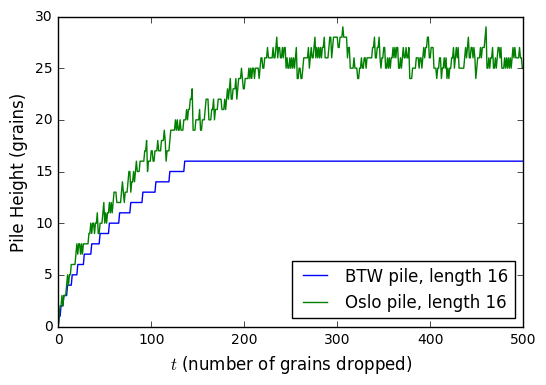

In [11]:
# reinitialise the piles
pile1.reset()
oslo_pile_xs.reset()

for i in (pile1, oslo_pile_xs):
    pile_heights = []
    
    # drop 500 grains
    for t in range(500):
        pile_heights.append(i.get_pile_height())
        i.drop_grain()
    plt.plot(pile_heights, label=i.name)
    
plt.xlabel("$t$ (number of grains dropped)", fontsize=12)
plt.ylabel("Pile Height (grains)", fontsize=12)
plt.legend(loc=0)
plt.show()

Arriving the recurring configurations, we can keep dropping grains to the *oslo_pile_xs* and the pile height should average to $\langle h \rangle=26.5$.

In [12]:
pile_heights = []

for i in range(10000):
    oslo_pile_xs.drop_grain()
    pile_heights.append(oslo_pile_xs.get_pile_height())
    
np.average(pile_heights)

26.535799999999998

As we can see, the Oslo model exhibits very different behaviours to the BTW model.  
These tests have also sufficiently proved the correctness of the program.

---

# Save/load Data
We first save the simulation data to a file, as simulating large system requires a lot of computational time.
The pile reaches a steady state when the last site topples. We can use this property to determine the amount of grains to drop.

~~~python

# Initialise piles
oslo_pile_xxs = Pile(8, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_xs = Pile(16, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_s = Pile(32, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_m = Pile(64, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_l = Pile(128, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_xl = Pile(256, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)
oslo_pile_xxl = Pile(512, OSLO_PROBS, POSSIBLE_THRESHOLD_SLOPES)

piles = (oslo_pile_xxs, oslo_pile_xs, oslo_pile_s, oslo_pile_m, oslo_pile_l, oslo_pile_xl, oslo_pile_xxl)
data_dict = OrderedDict()

# Populate piles
for pile in piles:
    pile_dict = {'heights': [], 'avalanche size': []}

    while not pile.is_at_steady_state:
        pile_dict['heights'].append(pile.get_pile_height())
        pile_dict['avalanche size'].append(pile.ava_size)
        pile.drop_grain()

    for _ in range(1000000):
        pile_dict['heights'].append(pile.get_pile_height())
        pile_dict['avalanche size'].append(pile.ava_size)
        pile.drop_grain()

    data_dict[pile.length] = pile_dict

pickle.dump(data_dict, open('height_and_avalanche_data', 'wb'))
    
~~~

When the pile reaches a recurrent state, we drop 1,000,000 more grains for later analysis. 

We can then load the data back into program:

In [13]:
data_dict = pickle.load(open('height_and_avalanche_data', 'rb'))
steady_state_time_period = 1000000

---

# Task 2a

## Height vs. Time Plots
Plot the pile height against time (number of grains dropped):

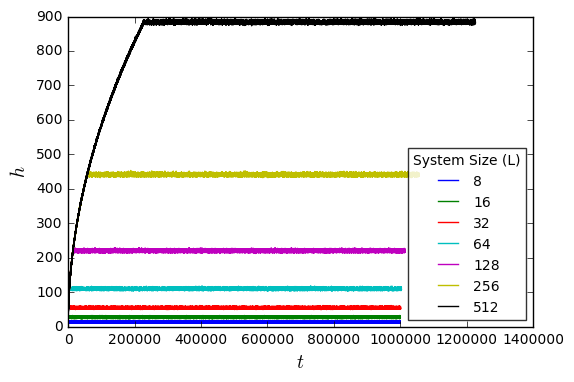

In [14]:
for length, pile_dict in data_dict.items():
    plt.plot(pile_dict['heights'], label=length)

plt.xlabel("$t$", fontsize=14)
plt.ylabel("$h$", fontsize=14)
plt.legend(loc=0, title="System Size (L)", framealpha=0.8, prop={'size':10})
plt.show()

As we can see, the height of the piles initially follows a curve. This is when the pile is still in transient configurations. At certain times, the heights flatten, denoting the corresponding piles reaching recurrent configurations.

To get a rough estimation of the cross-over times $(t_c(L))$, and pile height in the steady state $(h_c(L))$, we first find the moving average of the data and display them on a log-log plot:

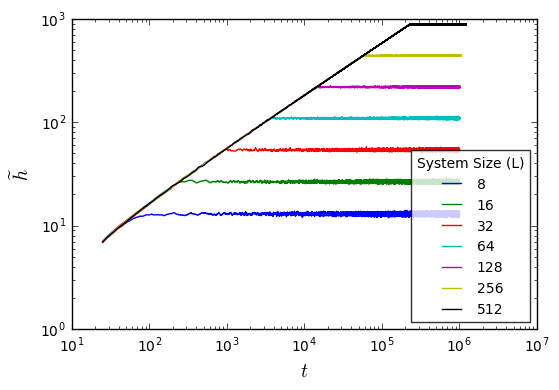

In [15]:
temporal_window = 50
start_time = int(temporal_window / 2)

for length, pile_dict in data_dict.items():
    smooth_data = analysis.np_moving_average(pile_dict['heights'], temporal_window)
    times = np.arange(start_time, len(smooth_data) + start_time)
    plt.loglog(times, smooth_data, label=length)

plt.xlabel("$t$", fontsize=14)
plt.ylabel("$\widetilde h$", fontsize=14)
plt.legend(loc=4, title="System Size (L)", framealpha=0.8, prop={'size':10})
plt.show()

We can then estimate the values by finding the intercepts of the lines.  

With these datapoints, we can determine the relationships:

$$t_c(L) \propto L^2$$  
$$h_c(L) \propto L$$

---

# Task 2b

## Data Collapse

Plot $\widetilde h/L$ against $t/L^2$:

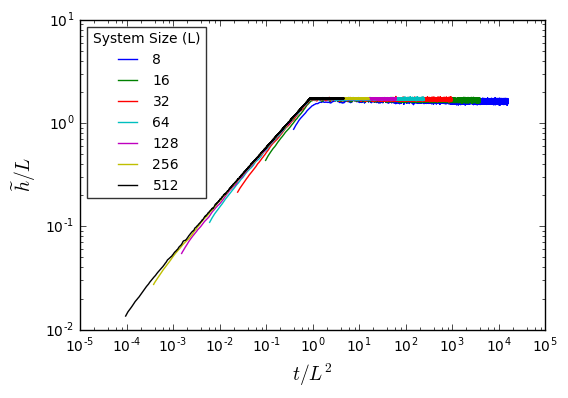

In [16]:
for length, pile_dict in data_dict.items():
    smooth_collapsed_heights = analysis.np_moving_average(pile_dict['heights'], temporal_window) / length
    collapsed_time = np.arange(start_time, len(smooth_collapsed_heights) + start_time) / length**2
    plt.loglog(collapsed_time, smooth_collapsed_heights, label=length)
    
plt.xlabel("$t/L^2$", fontsize=14)
plt.ylabel("$\widetilde h/L$", fontsize=14)
plt.legend(loc=0, title="System Size (L)", framealpha=0.8, prop={'size':10})
plt.show()

Zoom in into the cross over section, we see that the sharp transition is only evident in large $L$:

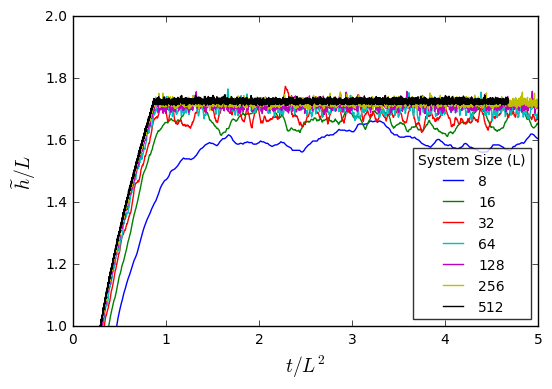

In [17]:
for length, pile_dict in data_dict.items():
    smooth_collapsed_heights = analysis.np_moving_average(pile_dict['heights'], temporal_window) / length
    collapsed_time = np.arange(start_time, len(smooth_collapsed_heights) + start_time) / length**2
    plt.plot(collapsed_time, smooth_collapsed_heights, label=length)
    
plt.axis((0.0, 5.0, 1.0, 2.0))
plt.xlabel("$t/L^2$", fontsize=14)
plt.ylabel("$\widetilde h/L$", fontsize=14)
plt.legend(loc=4, title="System Size (L)", framealpha=0.8, prop={'size':10})
plt.show()

$$\widetilde h\left(t; L\right) = L^{1}\mathcal{F}\left(\frac{t}{L^2}\right)$$  

As the system size tends to $\infty$, $\mathcal{F}(x)$ is discountinous at $x=1$. For $x < 1$, $\mathcal{F}(x)$ follows a power law. For $x \geqslant 1$, $\mathcal{F}(x)$ is constant.  

This is because the system experiences a phase trasition from the trasient state to the recurrent state, indicated by the non-zero outflux. 

Taking the data for $L = 512$, we can fit a power law to find how $\widetilde h\left(t; L\right)$ relates to $t$ in the transient state:

In [18]:
starting_t = 1000

height_data = data_dict[512]['heights'][starting_t:-steady_state_time_period]
t = np.arange(starting_t, len(height_data) + starting_t)

(a, p), cov = curve_fit(power_law, t, height_data)
a, p, analysis.calculate_std_from_cov_matrix(cov)

(1.7702056565687259,
 0.50356741637914126,
 array([  2.53017417e-04,   1.20708602e-05]))

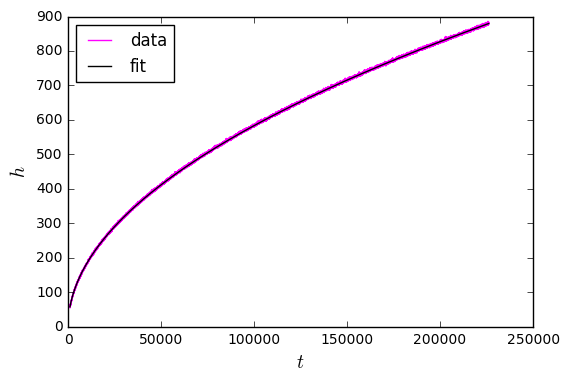

In [19]:
plt.plot(t, height_data, label='data', color='magenta')
plt.plot(t, power_law(t, a, p), label='fit', color='black')

plt.xlabel("$t$", fontsize=14)
plt.ylabel("$h$", fontsize=14)
plt.legend(loc=0)
plt.show()

---

# Task 2c

## Average Height vs. System Size
We can take the last 1,000,000 data points to calculate the average height at the steady state:

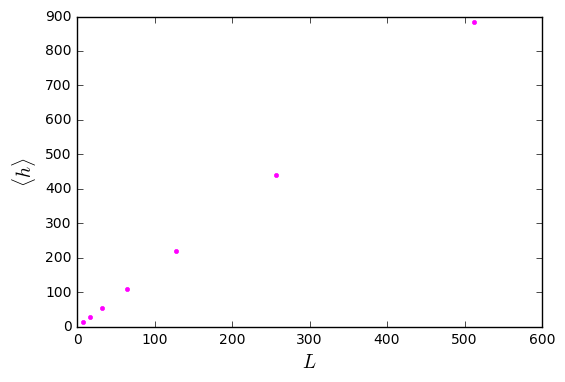

In [20]:
# Construct a dictionary to store the data points
system_lengths = np.array(list(data_dict.keys()))
average_heights = [np.average(pile_dict['heights'][-steady_state_time_period:]) for pile_dict in data_dict.values()]

plt.plot(system_lengths, average_heights, '.', color='magenta')

plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\langle h \rangle$", fontsize=14)
plt.show()

We see the line is not longer straight when system length is small. Boundary effects become siginificant

We first try fit with first order correction:

In [21]:
get_average_pile_height_from_L = lambda L, a0, a1, w1: a0 * L * (1 - a1 * L ** (-w1))

(a0, a1, w1), cov = curve_fit(get_average_pile_height_from_L, system_lengths, average_heights, absolute_sigma=True)

a0, a1, w1, analysis.calculate_std_from_cov_matrix(cov)

(1.7341713154661471,
 0.23849160098376307,
 0.61270912276215195,
 array([ 0.01385287,  0.35910523,  0.45789451]))

$$\langle h \rangle = a_0L(1 - a_1L^{-\omega_1})$$  
where $a_0 = \langle z \rangle = 1.734$, $a_1 = 0.238,$ and $\omega_1 = 0.613$

The uncertainties are high, because it is a 3 parameter optimisation. 

We can also obtain the parameters from taking the log of both side.  

$$log(a_0L-\langle h \rangle) = (1 - \omega_1) log(a_0a_1L)$$

Using the parameters, let's see how well the fit is:  

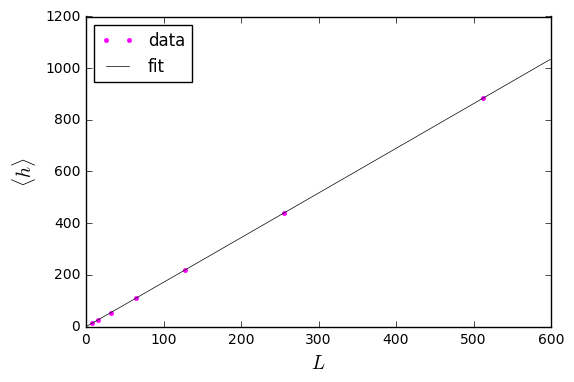

In [22]:
Ls = np.arange(1, 600)

plt.plot(system_lengths, average_heights, '.', color='magenta', label='data')
plt.plot(Ls, get_average_pile_height_from_L(Ls, a0, a1, w1), color='black', label='fit', linewidth=0.5)

plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\langle h \rangle$", fontsize=14)
plt.legend(loc=0)
plt.show()

We can clearly see the sign of corrections to scaling for small $L$:

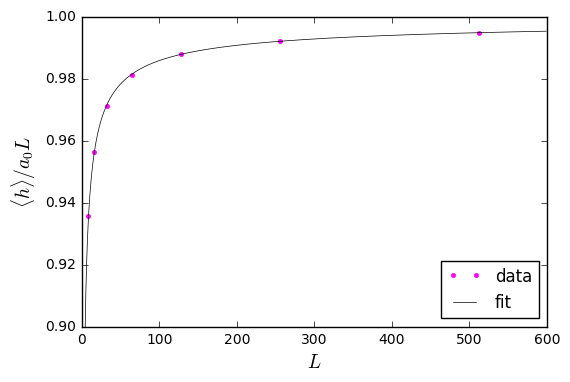

In [23]:
plt.plot(system_lengths, average_heights / (a0 * system_lengths), '.', color='magenta', label='data')
plt.plot(Ls, get_average_pile_height_from_L(Ls, a0, a1, w1) / (a0 * Ls), color='black', label='fit', linewidth=0.5)

plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\langle h \rangle /a_0L$", fontsize=14)
plt.axis((0, 600, 0.9, 1.0))
plt.legend(loc=4)
plt.show()

## Standard Deviation vs. System Size

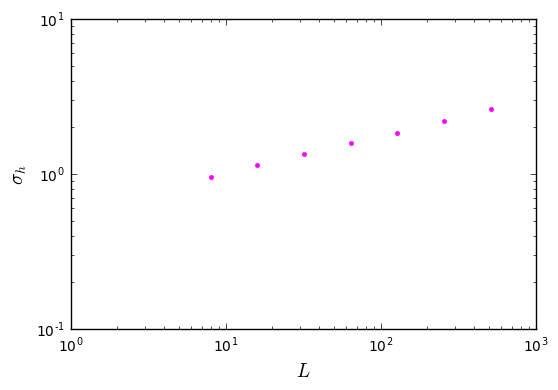

In [24]:
standard_deviations = [np.std(pile_dict['heights'][-steady_state_time_period:]) for pile_dict in data_dict.values()]
plt.loglog(system_lengths, standard_deviations, '.', color='magenta', label='data')

plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\sigma_h$", fontsize=14)
plt.show()

Looks like a power law relation, so:

In [25]:
(a, w), cov = curve_fit(power_law, system_lengths, standard_deviations)

a, w, analysis.calculate_std_from_cov_matrix(cov)

(0.58065343512392253, 0.24062723662009047, array([ 0.0059917 ,  0.00200217]))

$$\sigma_h(L)=aL^{\omega}$$  
where $a = 0.581$ and $\omega = 0.241$

Plotting on a loglog plot:

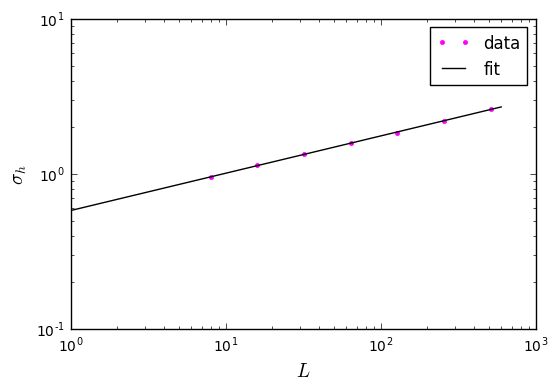

In [26]:
plt.loglog(system_lengths, standard_deviations, '.', color='magenta', label='data')
plt.loglog(Ls, power_law(Ls, a, w), color='black', label='fit')

plt.legend(loc=0)
plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\sigma_h$", fontsize=14)
plt.show()

Apply a technique similar to average height, we see no signs of scaling to correction:

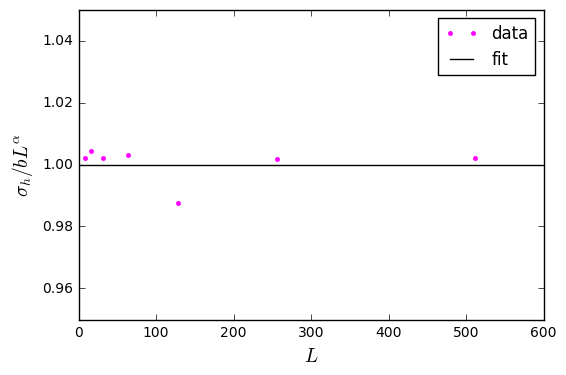

In [27]:
plt.plot(system_lengths, standard_deviations / (a * system_lengths ** w), '.', color='magenta', label='data')
plt.plot(Ls, power_law(Ls, a, w) / (a * Ls ** w), color='black', label='fit')

plt.legend(loc=0)
plt.xlabel("$L$", fontsize=14)
plt.ylabel(r"$\sigma_h/bL^{\alpha}$", fontsize=14)
plt.axis((0, 600, 0.95, 1.05))
plt.show()

$$\sigma_z = \sigma_h / L \sim L^{\omega-1} \sim L^{-0.759}$$  

So the average slope's standard deviation tends to 0 in the limit of $L \rightarrow \infty$  


---

# Task 2d

Plot height probability against height for the recurrent configurations:

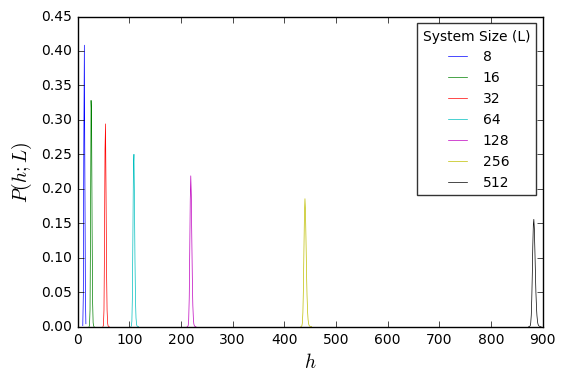

In [28]:
for length, pile_dict in data_dict.items():
    height_prob_dict = analysis.calculate_height_probability(pile_dict['heights'][-steady_state_time_period:])
    plt.plot(list(height_prob_dict.keys()), list(height_prob_dict.values()), '-', label=length, linewidth=0.5)
    
plt.legend(loc=0, title="System Size (L)",  framealpha=0.8, prop={'size':10})
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$P(h; L)$", fontsize=14)
plt.show()

Data collapse:

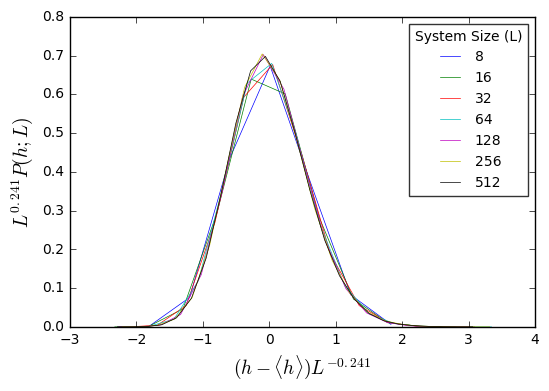

In [29]:
for length, pile_dict in data_dict.items():
    height_prob_dict = analysis.calculate_height_probability(pile_dict['heights'][-steady_state_time_period:])
    collapsed_h = (np.array(list(height_prob_dict.keys()))-average_heights[list(data_dict.keys()).index(length)]) / length ** w 
    collapsed_p = np.array(list(height_prob_dict.values())) * length ** w
    plt.plot(collapsed_h, collapsed_p, label=length, linewidth=0.5)
    
plt.legend(loc=0, title="System Size (L)",  framealpha=0.8, prop={'size':10})
plt.xlabel(r"$(h - \langle h \rangle) L^{-0.241}$", fontsize=14)
plt.ylabel("$L^{0.241}P(h; L)$", fontsize=14)
plt.show()

$$$$

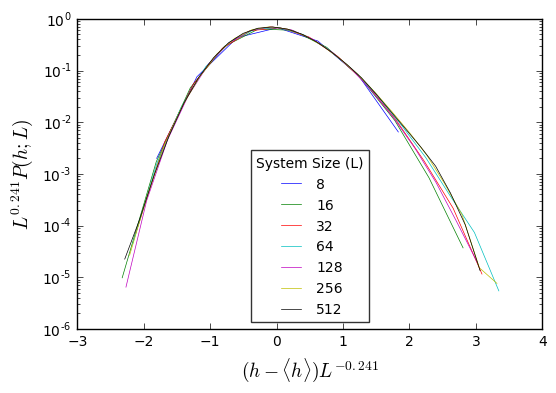

In [30]:
for length, pile_dict in data_dict.items():
    height_prob_dict = analysis.calculate_height_probability(pile_dict['heights'][-steady_state_time_period:])
    collapsed_h = (np.array(list(height_prob_dict.keys()))-average_heights[list(data_dict.keys()).index(length)]) / length ** w 
    collapsed_p = np.array(list(height_prob_dict.values())) * length ** w
    plt.semilogy(collapsed_h, collapsed_p, label=length, linewidth=0.5)
    
plt.legend(loc=0, title="System Size (L)",  framealpha=0.8, prop={'size':10})
plt.xlabel(r"$(h - \langle h \rangle) L^{-0.241}$", fontsize=14)
plt.ylabel("$L^{0.241}P(h; L)$", fontsize=14)
plt.show()

---

# Task 3a

## Avalanche size probability

Consider the system $L = 256$:

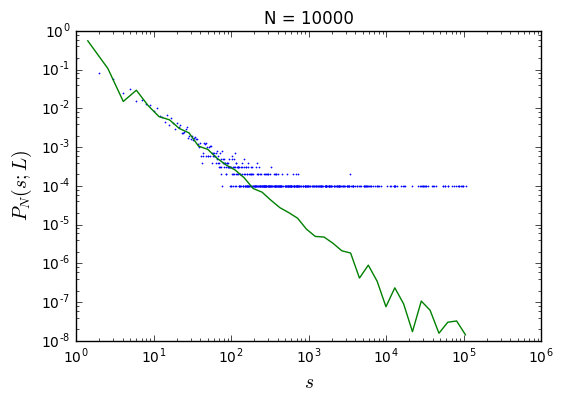

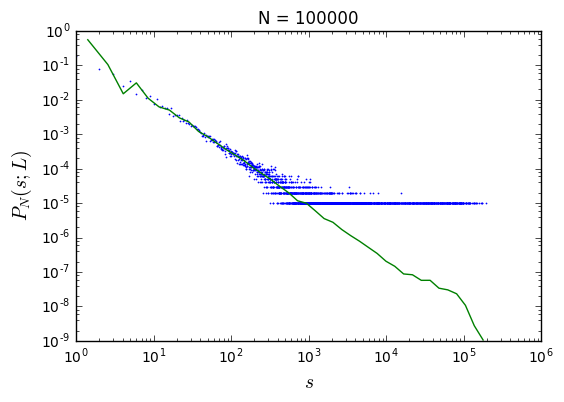

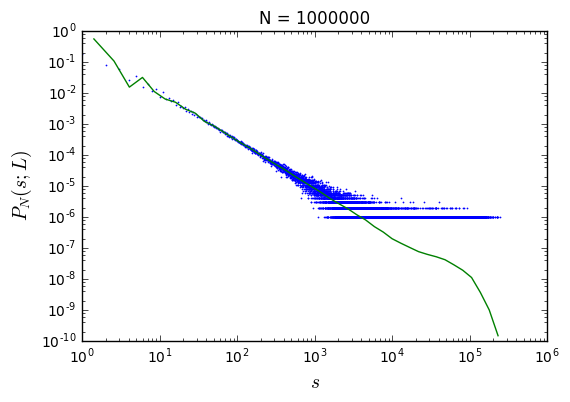

In [31]:
ava_size_256 = data_dict[256]['avalanche size']

no_of_samples = (10000, 100000, 1000000)

for i in no_of_samples:
    plt.figure()
    ava_size_prob_dict = analysis.calculate_avalanche_probability(ava_size_256[-i:])
    plt.loglog(list(ava_size_prob_dict.keys()), list(ava_size_prob_dict.values()), '.', ms=1.5)
    centres, probs = analysis.make_log_bins(ava_size_256[-i:], bin_scaling=1.3)
    plt.loglog(centres, probs, '-')
    plt.title("N = {}".format(i))
    plt.xlabel("$s$", fontsize=14)
    plt.ylabel("$P_N(s;L)$", fontsize=14)
    
plt.show()

$N$ needs to be large enough to see the cutoff effect.  
$a$ should be as small as possible, but the data points should produce a relatively smooth curve so we can analyse the trend.

---

# Task 3b

Choose $N=1,000,000$, plot the log-binned data for all system sizes:

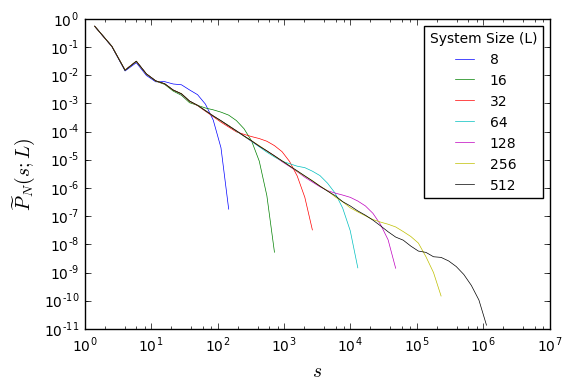

In [32]:
no_of_samples = 1000000

for length, pile_dict in data_dict.items():
    centres, probabilities = analysis.make_log_bins(pile_dict['avalanche size'][-no_of_samples:], bin_scaling=1.3)
    plt.loglog(centres, probabilities, '-', label=length, linewidth=0.5)

plt.legend(loc=0, title='System Size (L)', prop={'size':10})
plt.xlabel("$s$", fontsize=14)
plt.ylabel(r"$\widetilde P_N(s;L)$", fontsize=14)
plt.show()

Chose $a=1.3$ to produce smooth curves and remove noise.

Compare to $a=1.1$

[INSERT QUALITATIVE DESCRIPTION]

---

# Task 3c

Plot the probability against avalanche size graph for $L = 512$:

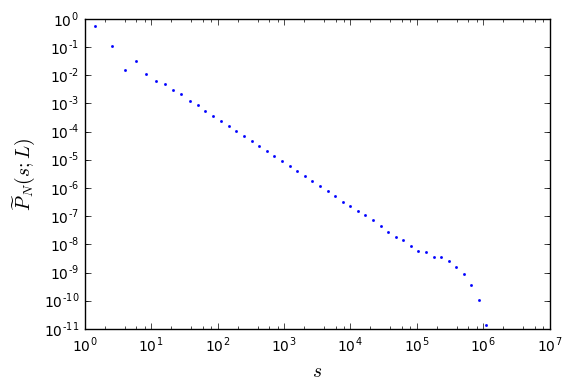

In [33]:
centres, probabilities = analysis.make_log_bins(data_dict[512]['avalanche size'][-no_of_samples:], bin_scaling=1.3)
plt.loglog(centres, probabilities, '.', ms=3.0)
plt.xlabel("$s$", fontsize=14)
plt.ylabel(r"$\widetilde P_N(s;L)$", fontsize=14)
plt.show()

We see that the data points follow a power law decay if we exclude the first 22 (s >> 1) and last 10 points. 

We can then fit it to estimate $\tau_s$:

In [34]:
power_law = lambda s, a, tau_s: a * s ** tau_s

(a, tau_s), cov = curve_fit(power_law, centres[22:-10], probabilities[22:-10])

a, tau_s, analysis.calculate_std_from_cov_matrix(cov)

(0.37498822445399005, -1.5522437883001861, array([ 0.01626898,  0.00592663]))

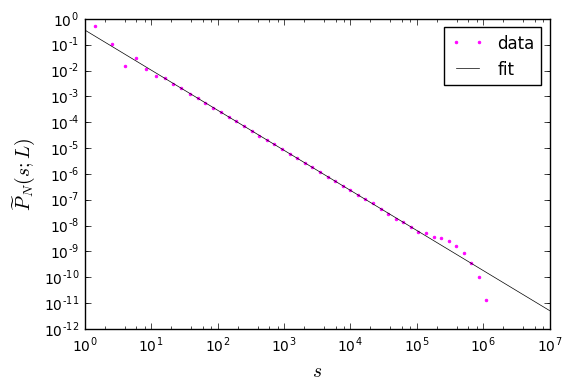

In [35]:
plt.loglog(centres, probabilities, '.', color='magenta', ms=4.0, label='data')

ava_sizes = np.logspace(0, 7, 100)
plt.loglog(ava_sizes, power_law(ava_sizes, a, tau_s), color='black', linewidth=0.5, label='fit')

plt.legend(loc=0)
plt.xlabel("$s$", fontsize=14)
plt.ylabel("$\widetilde P_N(s;L)$", fontsize=14)
plt.show()

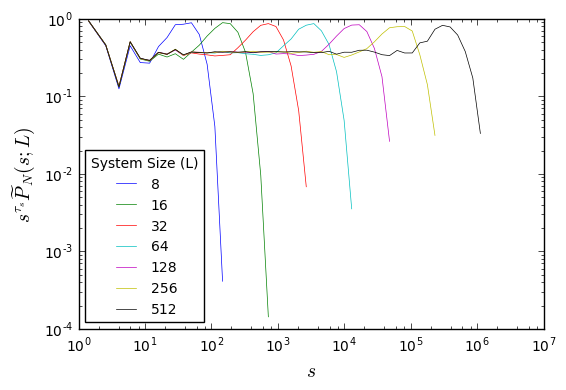

In [36]:
for length, pile_dict in data_dict.items():
    centres, probabilities = analysis.make_log_bins(pile_dict['avalanche size'][-no_of_samples:], bin_scaling=1.3)
    s_tau_probabilities = centres ** -tau_s * probabilities
    plt.loglog(centres, s_tau_probabilities, '-', label=length, linewidth=0.5)

plt.legend(loc=0, title='System Size (L)', prop={'size':10})
plt.xlabel("$s$", fontsize=14)
plt.ylabel(r"$s^{\tau_s} \widetilde P_N(s;L)$", fontsize=14)
plt.show()

Using the found $\tau_s$, try different values of $D$ to find the best collapse. Only data with system size larger than 128 $(L \gg 1)$ was plotted to make observations easier:

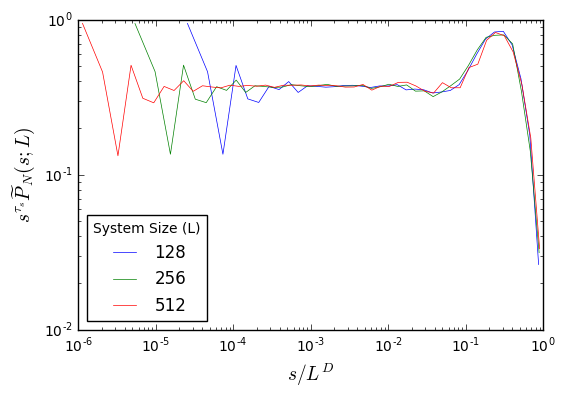

In [37]:
D = 2.25

for length, pile_dict in data_dict.items():
    if length >= 128:
        centres, probabilities = analysis.make_log_bins(pile_dict['avalanche size'][-no_of_samples:], bin_scaling=1.3)
        centre_L_minus_Ds = centres * length ** -D
        s_tau_probabilities = centres ** -tau_s * probabilities
        plt.loglog(centre_L_minus_Ds, s_tau_probabilities, '-', label=length, linewidth=0.5)
        
plt.legend(loc=0, title='System Size (L)')
plt.xlabel(r"$s/L^D$", fontsize=14)
plt.ylabel(r"$s^{\tau_s} \widetilde P_N(s;L)$", fontsize=14)
plt.show()

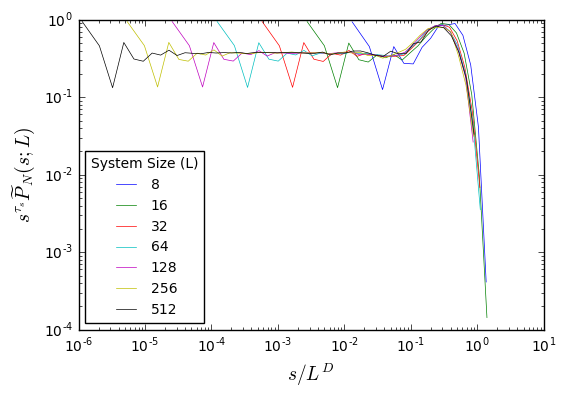

In [38]:
D = 2.25

for length, pile_dict in data_dict.items():
    centres, probabilities = analysis.make_log_bins(pile_dict['avalanche size'][-no_of_samples:], bin_scaling=1.3)
    centre_L_minus_Ds = centres * length ** -D
    s_tau_probabilities = centres ** -tau_s * probabilities
    plt.loglog(centre_L_minus_Ds, s_tau_probabilities, '-', label=length, linewidth=0.5)
        
plt.legend(loc=0, title='System Size (L)', prop={'size':10})
plt.xlabel(r"$s/L^D$", fontsize=14)
plt.ylabel(r"$s^{\tau_s} \widetilde P_N(s;L)$", fontsize=14)
plt.show()

We see the equation is indeed satisfied.  

$$\tau_s = 1.55$$  
$$D = 2.25$$  

Assuming $L \gg 1$, $s \gg 1$  

For $k = 1$,  
$$D(2-\tau_s)=1$$  

which is satisfied with these obtained values.

---

# Task 3d

Derive:  
$$\langle s^k \rangle \propto L^{D(1+k-\tau_s)}$$  

Measure the kth moment directly for $k = 1, 2, 3, 4, 5$:

In [39]:
ks = (1, 2, 3, 4, 5)
kth_moment_list = []

for k in ks:
    current_kth_moments = []
    for length, pile_dict in data_dict.items():
        kth_moment = np.average(np.array(pile_dict['avalanche size'][-steady_state_time_period:], dtype='float64') ** k)
        current_kth_moments.append([length, kth_moment])
    kth_moment_list.append(current_kth_moments)
    
kth_moment_array = np.array(kth_moment_list)

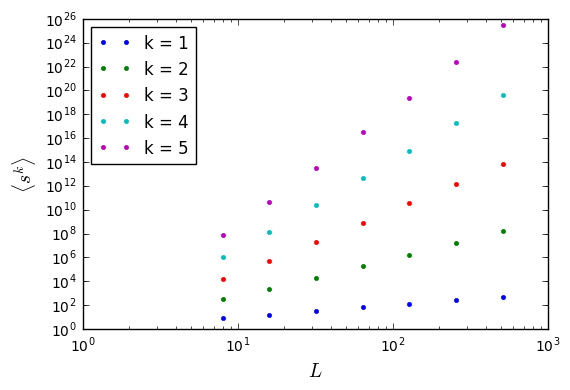

In [40]:
for i, k in enumerate(ks):
    plt.loglog(kth_moment_array[i, :, 0], kth_moment_array[i, :, 1], '.', label='k = {}'.format(k))

plt.legend(loc=0)
plt.xlabel('$L$', fontsize=14)
plt.ylabel(r'$\langle s^k \rangle$', fontsize=14)
plt.show()

Fit using only the last 3 data points ($L \gg 1$):

[0.00024137992940721932, 0.026529163661265513, 0.054685907080723829, 0.077179035951391722, 0.090536398278177249]
[0.9993869604844261, 3.2552244187566863, 5.5369306347520713, 7.829831028910025, 10.130461752936327]


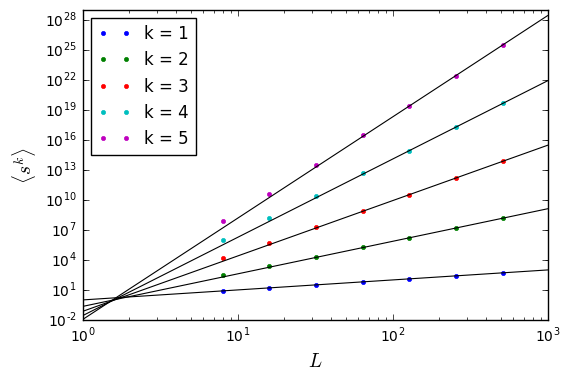

In [41]:
Ls = np.arange(0, 1000)
k_slopes = []
k_slope_errs = []

for i, k in enumerate(ks):
    plt.loglog(kth_moment_array[i, :, 0], kth_moment_array[i, :, 1], '.', label='k = {}'.format(k))
    
    (log_a, exp), cov = curve_fit(linear_regression, np.log(kth_moment_array[i, -3:, 0]), np.log(kth_moment_array[i, -3:, 1]))
    plt.loglog(Ls, power_law(Ls, np.exp(log_a), exp), color='black', linewidth=0.8)
    k_slopes.append(exp)
    k_slope_errs.append(analysis.calculate_std_from_cov_matrix(cov)[1])
    
print(k_slope_errs)
print(k_slopes)
plt.legend(loc=0)
plt.xlabel('$L$', fontsize=14)
plt.ylabel(r'$\langle s^k \rangle$', fontsize=14)
plt.show()

-1.27277730681 2.27216322177 [ 0.00588701  0.00588489]
1.56016103712


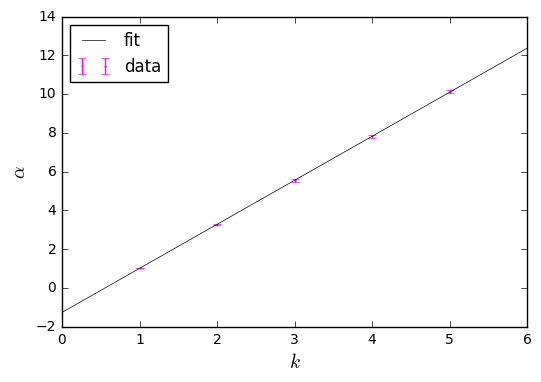

In [42]:
(c, D), cov = curve_fit(linear_regression, ks, k_slopes, sigma=k_slope_errs)
print(c, D, analysis.calculate_std_from_cov_matrix(cov))

tau_s = 1 - c / D
print(tau_s)

plt.errorbar(ks, k_slopes, yerr=k_slope_errs, color='magenta', fmt='.', label='data', ms=2.0)

ks_ = np.arange(7)
plt.plot(ks_, linear_regression(ks_, c, D), color='black', label='fit', linewidth=0.5)

plt.legend(loc=0)
plt.xlabel('$k$', fontsize=14)
plt.ylabel(r'$\alpha$', fontsize=14)
plt.show()